In [118]:
import os
import cv2 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Reading the image

In [119]:
ds_path = 'plantdata\\apple___healthy'

In [120]:
test_img_apple = ds_path + '\\7be4cfca-8984-4624-ac7e-94d19aa2e5fe___RS_HL 7656.jpg'

(1200, 1600, 3)

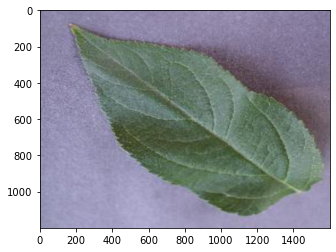

In [121]:
main_img = cv2.imread(test_img_apple)
img = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
re_img = cv2.resize(img, (1600, 1200))
plt.imshow(re_img)
re_img.shape

## Converting image to gray scale

(1200, 1600)

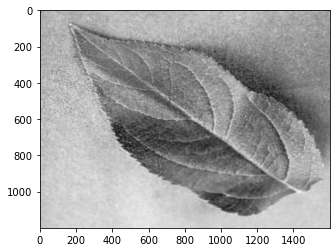

In [37]:
# grayscale simplifies the algorithm and reduces computational requirements

gs = cv2.cvtColor(re_img,cv2.COLOR_RGB2GRAY)
plt.imshow(gs,cmap="Greys_r")
gs.shape

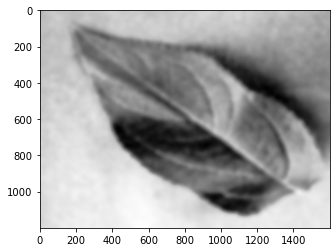

In [117]:
#Its main purpose is removing noise from images. 
#This means it is very versatile and can be the base for a photo editing filter 
#To prepare images for further processing.

blur = cv2.GaussianBlur(gs, (75,75),0)
plt.imshow(blur,cmap="Greys_r")

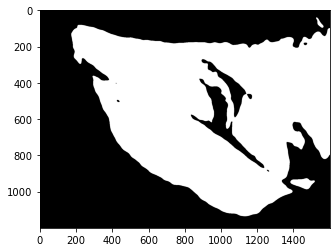

In [125]:
#Image thresholding is a simple form of image segmentation.
#It is a way to create a binary image from a grayscale or full-color image. 
#This is typically done in order to separate "object" or foreground pixels from background pixels to aid in image processing.
#Useful for Contouring.

ret_otsu,im_bw_otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(im_bw_otsu,cmap='Greys_r')

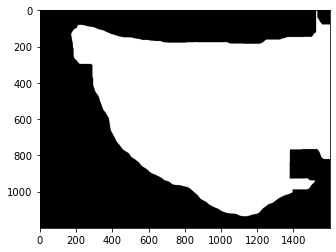

In [128]:
#Morphology Closing
#Useful in closing small holes inside the foreground objects, or small black points on the object.

kernel = np.ones((85,85),np.uint8)
closing = cv2.morphologyEx(im_bw_otsu, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing,cmap="Greys_r")

## Finding contours

In [138]:
#Contours is a curve joining all the continuous points(along the boundary), having same color or intensity.
#For better accuracy, we used binary images. So before finding contours, apply threshold.

In [130]:
contours,hierarchy =  cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [131]:
len(contours)

1

## Finding the correct leaf contour from the list of contours

In [149]:
#The following function finds the correct leaf contour by taking any coordinate point of the leaf (default - center point) 
#and checks whether the current contour contains that point or not. Returns the index of the correct contour.
#PointPolygonTest function determines whether the point is inside a contour, outside, or lies on an edge

def find_contour(cnts):
    contains = []
    y_ri,x_ri,_ = re_img.shape #Initializing the points (1200,1600,3).
    for cc in cnts:
        yn = cv2.pointPolygonTest(cc,(x_ri//2,y_ri//2),False) #checks if it lies inside
        contains.append(yn)

    val = [contains.index(i) for i in contains if i>0]
    print(contains)
    return val[0] #Points which are inside the contour and on the edge.

## Creating mask image for background subtraction using leaf contour

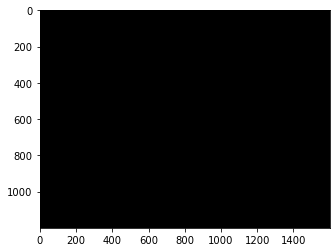

In [158]:
#Creating a black image with dimensions 1200 X 1600.

black_img = np.empty([1200,1600,3],dtype=np.uint8)
black_img.fill(0)
plt.imshow(black_img,cmap="Greys_r")

### The drawContours() function

The drawContours() function to overlay the contours on the RGB image. 
This function has four required and several optional arguments.

image: This is the input RGB image on which you want to draw the contour.

contours: Indicates the contours obtained from the findContours() function.

contourIdx: The pixel coordinates of the contour points are listed in the obtained contours. Using this argument, you can specify the index position from this list, indicating exactly which contour point you want to draw. Providing a negative value will draw all the contour points.

color: This indicates the color of the contour points you want to draw. We are drawing the points in green.

thickness: This is the thickness of contour points.

[1.0]


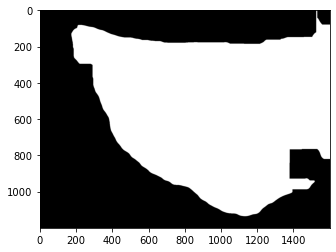

In [172]:
index = find_contour(contours)
cnt = contours[index]
mask = cv2.drawContours(black_img, [cnt] , 0, (255,255,255), -1)
plt.imshow(mask)

## Performing masking operation on the origial image

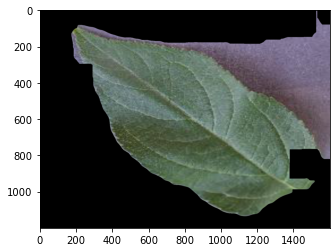

In [173]:
#Merging the given images using bitwise_and operator
#re_img = source image
#Here we are masking the original leaf image with our "mask" image.

maskedimg = cv2.bitwise_and(re_img, mask, mask=None) 
plt.imshow(maskedimg)

In [162]:
#Conversion of black background to white background

white_pix = [255,255,255]
black_pix = [0,0,0]

final_img = maskedimg
h,w,channels = final_img.shape
for x in range(0,w):
    for y in range(0,h):
        channels_xy = final_img[y,x]
        if all(channels_xy == black_pix):    
            final_img[y,x] = white_pix

## Background subtracted image

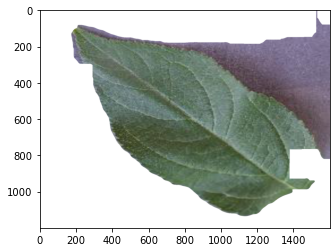

In [174]:
plt.imshow(final_img)

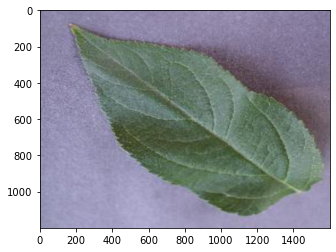

In [164]:
plt.imshow(re_img)